In [42]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

# --- Database connection details ---
DB_HOST = 'localhost'
DB_USER = 'gmaayan'
DB_PASSWORD = 'j.UyNY.3NsP6vrdfy3LNq.2f'
DB_NAME = 'tweets'

In [57]:
# --- Connect to the database ---
db_connection = mysql.connector.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    charset="utf8mb4",
    collation="utf8mb4_unicode_ci"
)

# Create a cursor object
cursor = db_connection.cursor()

In [24]:
# --- Define your query ---
query = """
SELECT
  noteId,
  COUNT(*) AS note_count
FROM note_ratings
WHERE helpfulnessLevel = HELPFUL
GROUP BY noteId
ORDER BY note_count DESC;
"""

# --- Execute the query ---
cursor.execute(query)

# Fetch all results
results = cursor.fetchall()

# store the results in a pandas dataframe
df2 = pd.DataFrame(results, columns=['noteId', 'note_count'])

print(df2.head())

                noteId  note_count
0  1681713296271892480       20086
1  1727782563186618856       13309
2  1649126162742771733       11414
3  1661796202554294297       11334
4  1641632910263431169        9662


In [77]:
print(df2.shape)

(1618339, 2)


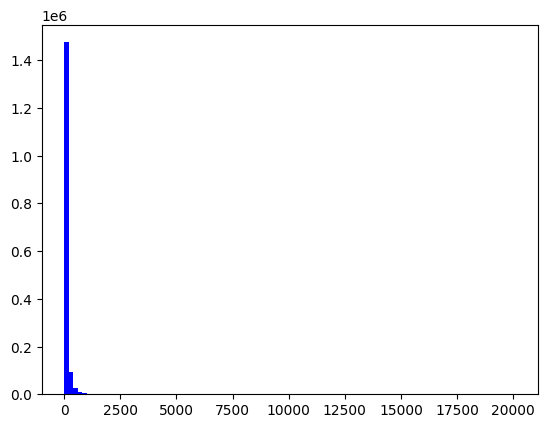

In [16]:
query = """
SELECT agree, disagree, helpfulnessLevel, helpful FROM note_ratings
WHERE noteId = 1681713296271892480
"""

cursor.execute(query)
results = cursor.fetchall()
df3 = pd.DataFrame(results, columns=['agree', 'disagree', 'helpfulnessLevel', 'helpful'])

# plot histogram of note counts
plt.hist(df['note_count'], bins=100, color='blue')
plt.show()

In [51]:
print(df3.head())
print(df3['helpfulnessLevel'].value_counts())

   agree  disagree helpfulnessLevel  helpful
0      0         0          HELPFUL        0
1      0         0          HELPFUL        0
2      0         0          HELPFUL        0
3      0         0          HELPFUL        0
4      0         0          HELPFUL        0
helpfulnessLevel
HELPFUL             19629
NOT_HELPFUL           344
SOMEWHAT_HELPFUL      113
Name: count, dtype: int64


In [27]:
df4 = df2[df2['note_count'] > 500]
print(df4.shape)

(33530, 2)


In [79]:
query = """
SELECT 
  r.noteId,
  n.tweetId,
  COUNT(r.noteId) AS note_count
FROM note_ratings AS r
JOIN notes AS n 
    ON r.noteId = n.noteId
WHERE r.helpfulnessLevel = 'HELPFUL'
GROUP BY r.noteId, n.tweetId
HAVING COUNT(r.noteId) > 400
ORDER BY note_count DESC
"""

cursor.execute(query)
results = cursor.fetchall()
df5 = pd.DataFrame(results, columns=['noteId', 'tweetId', 'note_count'])
print(df5.shape)
print(df5.head())

(20558, 3)
                noteId              tweetId  note_count
0  1681713296271892480  1672908357081124864       19629
1  1727782563186618856  1727461993978667335       12294
2  1649126162742771733  1649118738120048654       10161
3  1742503434299838827  1742455903264129474        8813
4  1819180232974254554  1819083423077880215        8700


In [81]:
# get the top 50 tweetIds
top_tweetIds = list(df5['tweetId'].unique())

# save the top tweetIds to a pickle file
with open('top_tweetIds.pkl', 'wb') as f:
    pkl.dump(top_tweetIds, f)

In [80]:
print(df5['tweetId'].unique().shape)

(13683,)


In [46]:
# get note ids for the top tweetIds
# query = """
# SELECT id from tweets
# """
# cursor.execute(query)
# results = cursor.fetchall()
# tweet_ids = list(results)
# tweet_ids = [id[0] for id in tweet_ids]
# print (tweet_ids)

filtered_notes = df5[df5['tweetId'].isin(tweet_ids)]
print(filtered_notes.shape)

(100, 3)


In [47]:
# get full notes for the filtered notes
placeholders = ", ".join(["%s"] * len(filtered_notes))
query = f"""SELECT 
    noteId,
    tweetId,
    classification,
    believable,
    harmful,
    misleadingOther,
    misleadingFactualError,
    misleadingManipulatedMedia,
    misleadingOutdatedInformation,
    misleadingMissingImportantContext,
    misleadingUnverifiedClaimAsFact,
    misleadingSatire,
    notMisleadingOther,
    notMisleadingFactuallyCorrect,
    notMisleadingOutdatedButNotWhenWritten,
    notMisleadingClearlySatire,
    notMisleadingPersonalOpinion
FROM notes WHERE noteId IN ({placeholders})"""
cursor.execute(query, tuple(filtered_notes['noteId']))
results = cursor.fetchall()
full_notes = pd.DataFrame(results, columns=[
    'noteId', 
    'tweetId', 
    'classification', 
    'believable', 
    'harmful', 
    'misleadingOther', 
    'misleadingFactualError', 
    'misleadingManipulatedMedia', 
    'misleadingOutdatedInformation', 
    'misleadingMissingImportantContext', 
    'misleadingUnverifiedClaimAsFact', 
    'misleadingSatire', 
    'notMisleadingOther', 
    'notMisleadingFactuallyCorrect', 
    'notMisleadingOutdatedButNotWhenWritten', 
    'notMisleadingClearlySatire', 
    'notMisleadingPersonalOpinion'
])
print(full_notes.shape)
print(full_notes.head())

(100, 17)
                noteId              tweetId  \
0  1590463688397430784  1528684321254608896   
1  1603581631385817089  1603576251125362688   
2  1614426356342833154  1614350513331470338   
3  1618423074046578689  1618056920199200768   
4  1641632910263431169  1641594971462541315   

                          classification believable harmful  misleadingOther  \
0  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   
1  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   
2  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   
3  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   
4  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   

   misleadingFactualError  misleadingManipulatedMedia  \
0                       1                           0   
1                       0                           0   
2                       0                           0  

In [50]:
print(full_notes[full_notes['classification']=='NOT_MISLEADING'])
print(full_notes[full_notes['tweetId'] == 1852946465850622228])

                 noteId              tweetId  classification believable  \
87  1853170559976399351  1852946465850622228  NOT_MISLEADING              

   harmful  misleadingOther  misleadingFactualError  \
87                        0                       0   

    misleadingManipulatedMedia  misleadingOutdatedInformation  \
87                           0                              0   

    misleadingMissingImportantContext  misleadingUnverifiedClaimAsFact  \
87                                  0                                0   

    misleadingSatire  notMisleadingOther  notMisleadingFactuallyCorrect  \
87                 0                   0                              1   

    notMisleadingOutdatedButNotWhenWritten  notMisleadingClearlySatire  \
87                                       0                           0   

    notMisleadingPersonalOpinion  
87                             0  
                 noteId              tweetId  \
87  1853170559976399351  185294646585062

In [52]:
# get all ratings for the notes
query = f"""SELECT 
    noteId,
    raterParticipantId,
    helpfulnessLevel,
    ratedOnTweetId
FROM note_ratings WHERE noteId IN ({placeholders})"""
cursor.execute(query, tuple(filtered_notes['noteId']))
results = cursor.fetchall()
full_ratings = pd.DataFrame(results, columns=[
    'noteId', 
    'raterParticipantId', 
    'helpfulnessLevel', 
    'ratedOnTweetId'
])
print(full_ratings.shape)
print(full_ratings.head())

(419580, 4)
                noteId                                 raterParticipantId  \
0  1590463688397430784  0003AFB7D3568236C3C8509208C76BDA2B04A04BA33037...   
1  1590463688397430784  000618D62D26469C059F4690178D06CB5483B122126D32...   
2  1590463688397430784  0024F6A10A199C0F82E54B02006D7684E59E69BD02AC22...   
3  1590463688397430784  0025DCB5E90CCF3EC7662396E5EC712CC0C5F909911795...   
4  1590463688397430784  002A62303516D0CCE7BCBD143AE53FACB0FE03168AEA4E...   

  helpfulnessLevel  ratedOnTweetId  
0      NOT_HELPFUL              -1  
1          HELPFUL              -1  
2          HELPFUL              -1  
3          HELPFUL              -1  
4          HELPFUL              -1  


In [58]:
# get all tweets
query = f"""
SELECT 
    id,
    text,
    created_at,
    author_id,
    retweet_count,
    reply_count,
    like_count,
    quote_count,
    bookmark_count,
    impression_count,
    interaction_score
FROM tweets
"""
cursor.execute(query)
results = cursor.fetchall()
full_tweets = pd.DataFrame(results, columns=[
    'id', 
    'text', 
    'created_at', 
    'author_id', 
    'retweet_count', 
    'reply_count', 
    'like_count', 
    'quote_count', 
    'bookmark_count', 
    'impression_count',
    'interaction_score'
])

print(full_tweets.shape)
print(full_tweets.head())

(44, 11)
                    id                                               text  \
0  1528684321254608896  Elon musk has changed Twitter like button from...   
1  1603576251125362688                       I love Barbara Streisand lol   
2  1607579099031302147                       Rebound bullet to kill enemy   
3  1614350513331470338  NASA finds a perfectly cut, trillion-ton recta...   
4  1618056920199200768  Welcome to @elonmusk’s Twitter where literal s...   

           created_at            author_id  retweet_count  reply_count  \
0 2022-05-23 10:28:38            741052232           6964         8808   
1 2022-12-16 02:22:25             44196397           6384        14135   
2 2022-12-27 03:28:19  1100982077636280321           6742         3732   
3 2023-01-14 19:55:30   750683331260321792          19872         4497   
4 2023-01-25 01:23:26  1524149141835821057           1873        17429   

   like_count  quote_count  bookmark_count  impression_count  \
0      650062      

In [59]:
full_data = {
    'notes': full_notes,
    'ratings': full_ratings,
    'tweets': full_tweets
}

with open('full_data.pkl', 'wb') as f:
    pkl.dump(full_data, f)

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
full_tweets[['scaled_interactions']] = scaler.fit_transform(full_tweets[['interaction_score']])

print(full_tweets[['interaction_score', 'scaled_interactions']].describe())



                 id                     created_at     author_id  \
count  4.400000e+01                             44  4.400000e+01   
mean   1.724683e+18  2023-11-15 06:57:13.227272448  4.568464e+17   
min    1.528684e+18            2022-05-23 10:28:38  9.390910e+05   
25%    1.653250e+18  2023-05-02 04:08:06.750000128  4.379837e+07   
50%    1.720372e+18            2023-11-03 09:25:21  2.549563e+08   
75%    1.817222e+18     2024-07-27 15:35:21.500000  1.100982e+18   
max    1.870187e+18            2024-12-20 19:16:54  1.643343e+18   
std    8.807566e+16                            NaN  6.374060e+17   

       retweet_count   reply_count     like_count   quote_count  \
count      44.000000     44.000000      44.000000     44.000000   
mean     8051.500000  11848.954545   88682.295455   7447.818182   
min       284.000000      3.000000    2411.000000    304.000000   
25%      1372.250000   1937.500000    6592.000000   2820.000000   
50%      3370.500000   9540.500000   18949.500000   

In [64]:
# get ratings score for notes
ratings_map = {
    'HELPFUL': 1,
    'SOMEWHAT_HELPFUL': 0,
    'NOT_HELPFUL': -1
}

full_ratings['rating_score'] = full_ratings['helpfulnessLevel'].map(ratings_map)
print(full_ratings[['helpfulnessLevel', 'rating_score']].describe())

note_ratings = full_ratings[['noteId', 'rating_score']].groupby('noteId').mean().reset_index()
# add note_ratings to full_notes
full_notes = full_notes.merge(note_ratings, on='noteId', how='left')
print(full_notes[['rating_score']].describe())

        rating_score
count  419580.000000
mean        0.821257
std         0.554933
min        -1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
       rating_score
count    100.000000
mean       0.750049
std        0.216739
min        0.074638
25%        0.664701
50%        0.822089
75%        0.914141
max        0.985006


In [65]:
# check note types
note_types = full_notes[
    ['misleadingManipulatedMedia',
     'misleadingMissingImportantContext',
     'misleadingUnverifiedClaimAsFact',
     'misleadingFactualError',
     'misleadingOutdatedInformation',
     'misleadingSatire',
     'misleadingOther',
     'notMisleadingOutdatedButNotWhenWritten',
     'notMisleadingPersonalOpinion',
     'notMisleadingClearlySatire',
     'notMisleadingOther',
     'notMisleadingFactuallyCorrect']].sum(axis=1)

print(note_types.value_counts())

1    49
2    33
3    12
4     3
5     2
6     1
Name: count, dtype: int64


In [68]:
full_notes.loc[full_notes['misleadingManipulatedMedia'] == 1, 'misleadingManipulatedMedia'] = -3
full_notes.loc[full_notes['misleadingMissingImportantContext'] == 1, 'misleadingMissingImportantContext'] = -3

full_notes.loc[full_notes['misleadingUnverifiedClaimAsFact'] == 1, 'misleadingUnverifiedClaimAsFact'] = -2
full_notes.loc[full_notes['misleadingFactualError'] == 1, 'misleadingFactualError'] = -2

full_notes.loc[full_notes['misleadingOutdatedInformation'] == 1, 'misleadingOutdatedInformation'] = -1
full_notes.loc[full_notes['misleadingSatire'] == 1, 'misleadingSatire'] = -1
full_notes.loc[full_notes['misleadingOther'] == 1, 'misleadingOther'] = -1


full_notes.loc[full_notes['notMisleadingOutdatedButNotWhenWritten'] == 1, 'notMisleadingOutdatedButNotWhenWritten'] = 1

full_notes.loc[full_notes['notMisleadingPersonalOpinion'] == 1, 'notMisleadingPersonalOpinion'] = 2
full_notes.loc[full_notes['notMisleadingClearlySatire'] == 1, 'notMisleadingClearlySatire'] = 2
full_notes.loc[full_notes['notMisleadingOther'] == 1, 'notMisleadingOther'] = 2

full_notes.loc[full_notes['notMisleadingFactuallyCorrect'] == 1, 'notMisleadingFactuallyCorrect'] = 3

full_notes['type_min'] = full_notes[
    ['misleadingManipulatedMedia',
     'misleadingMissingImportantContext',
     'misleadingUnverifiedClaimAsFact',
     'misleadingFactualError',
     'misleadingOutdatedInformation',
     'misleadingSatire',
     'misleadingOther',
     'notMisleadingOutdatedButNotWhenWritten',
     'notMisleadingPersonalOpinion',
     'notMisleadingClearlySatire',
     'notMisleadingOther',
     'notMisleadingFactuallyCorrect']].min(axis=1)
full_notes['externality'] = full_notes['type_min'] - full_notes['rating_score']

scaler = MinMaxScaler(feature_range=(-1, 1))
full_notes[['externality']] = scaler.fit_transform(full_notes[['externality']])
print(full_notes[['externality']].describe())

       externality
count   100.000000
mean     -0.643219
std       0.434239
min      -1.000000
25%      -0.934709
50%      -0.835489
75%      -0.420113
max       1.000000


In [72]:
# add the notes score to the tweets
notes_score_by_tweet = full_notes[['tweetId', 'externality']].groupby('tweetId').mean().reset_index()
full_tweets = full_tweets.merge(notes_score_by_tweet, left_on='id', right_on='tweetId', how='left')
print(full_tweets[['scaled_interactions','externality']].describe())

       interaction_score  externality
count          43.000000    44.000000
mean            0.003072    -0.682528
std             0.004036     0.342551
min             0.000142    -1.000000
25%             0.000885    -0.937030
50%             0.001536    -0.849356
75%             0.003858    -0.426253
max             0.022429     0.324555


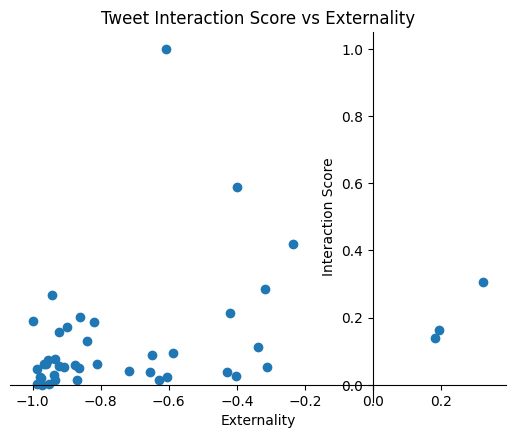

In [76]:
# plot scaled interactions vs externality

fig, ax = plt.subplots()

ax.scatter(full_tweets['externality'], full_tweets['scaled_interactions'])
ax.set_xlabel('Externality')
ax.set_ylabel('Interaction Score')
ax.set_title('Tweet Interaction Score vs Externality')

# Move the left spine (which is normally at x=min) to x=0
ax.spines['left'].set_position('zero')
# Hide the right spine
ax.spines['right'].set_color('none')

# If you also want the x-axis drawn at y=0, do likewise:
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

# Set tick positions so they show on the moved spines
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.show()

In [55]:
# --- Clean up ---
cursor.close()
db_connection.close()